In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/DLCG_PART_2/face_images.zip" -d "/content/data"


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import cv2
import os
import glob

In [ ]:
img_data = []
for img in os.listdir("/content/data/face_images"):
  img_file = cv2.imread("/content/data/face_images/" + img)
  if(type(img_file) != type(None)):
    img_data.append(img_file)

In [ ]:
len(img_data)

750

In [ ]:
# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5
import random

def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

# HORIZONTAL SHIFT - RANDOM RATIO 0 - 1
def horizontal_shift(img, ratio=0.0):
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, h, w)
    return img

# VERTICAL SHIFT - RANDOM RATIO 0 - 1
def vertical_shift(img, ratio=0.0):
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, h, w)
    return img

# BRIGHTNESS - RANDOM LOW, HIGH 
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

# ZOOM - RANDOM VALUE 0 - 1
def zoom(img, value):
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, h, w)
    return img

# HORIZONTAL FLIP - RANDOM BOOLEAN
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

# VERTICAL FLIP - RANDOM BOOLEAN
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

# ROTATION - RANDOM ANGLE
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img
  
# SCALE - RANDOM VALUE 0.6 - 1
def scale(img, value):
  return np.array((value * img), dtype=np.uint8)

In [ ]:
img_augmented_data = []
for i in img_data:
  img_augmented_data.append(i)
  for j in range(3):
    img_augmented_data.append(horizontal_shift(i, random.uniform(0, 1)))
    img_augmented_data.append(vertical_shift(i, random.uniform(0, 1)))
    img_augmented_data.append(zoom(i, random.uniform(0, 1)))
    img_augmented_data.append(scale(i, random.uniform(0.6, 1)))

In [ ]:
L_data = []
a_data = []
b_data = []
for img in img_augmented_data:
  imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L, a, b = cv2.split(imageLAB)
  L_data.append(L)
  a_data.append(a)
  b_data.append(b)

In [ ]:
X_data = np.array(L_data, dtype = np.uint8)
X_data = X_data / 255
X_data.shape , np.amax(X_data)

((9750, 128, 128), 0.996078431372549)

In [ ]:
y_data = []
for i in range(len(a_data)):
  y_data.append([a_data[i], b_data[i]])
y_data = np.array(y_data, dtype = np.float32)
y_data = y_data / 255
y_data.shape

(9750, 2, 128, 128)

In [ ]:
import random
train_indices = []
for i in range(8775):
  x = random.randint(0, 9749)
  while(x in train_indices):
    x = random.randint(0, 9749)
  train_indices.append(x)
print(len(train_indices))
train_indices = list(set(train_indices))
print(len(train_indices))

8775
8775


In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []

for i in range(9750):
  if(i in train_indices):
    X_train.append(X_data[i])
    y_train.append(y_data[i])
  else:
    X_test.append(X_data[i])
    y_test.append(y_data[i])

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test= np.array(y_test, dtype=np.float32)
X_train = X_train.reshape(8775 ,1, 128, 128)
X_test = X_test.reshape(975 ,1, 128, 128)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8775, 1, 128, 128),
 (975, 1, 128, 128),
 (8775, 2, 128, 128),
 (975, 2, 128, 128))

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization
model = Sequential()
model.add(Input(shape = (X_train[0].shape)))
model.add(Conv2D(128, 2, activation = "relu",strides = 1,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(64, 2, activation = "relu",strides = 2,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(32, 2, activation = "relu",strides = 2,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(16, 2, activation = "relu",strides = 2,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(8, 2, activation = "relu",strides = 2,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2D(4, 2, activation = "relu",strides = 2,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(8, 2, activation = "relu",strides = 2,padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(16, 2, activation = "relu",strides = (1 , 2),padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(32, 2, activation = "relu",strides = (1 , 2),padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(64, 2, activation = "relu",strides = (1 , 2),padding = 'same'))
model.add(BatchNormalization())
model.add(Conv2DTranspose(128, 2, activation = "relu",strides = (1 , 2),padding = 'same'))

model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_264 (Conv2D)         (None, 1, 128, 128)       65664     
                                                                 
 batch_normalization (BatchN  (None, 1, 128, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_265 (Conv2D)         (None, 1, 64, 64)         32832     
                                                                 
 batch_normalization_1 (Batc  (None, 1, 64, 64)        256       
 hNormalization)                                                 
                                                                 
 conv2d_266 (Conv2D)         (None, 1, 32, 32)         8224      
                                                                 
 batch_normalization_2 (Batc  (None, 1, 32, 32)      

In [ ]:
loss = tf.keras.losses.MeanSquaredError(name='mean_squared_error')
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lrr = ReduceLROnPlateau(monitor='val_loss', 
                        patience=5, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.0001)

In [ ]:
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=50, 
                    batch_size=512,
                    steps_per_epoch=X_train.shape[0]//512,
                    validation_steps=X_test.shape[0]//512,
                    callbacks=[lrr],
                    shuffle=True)

Epoch 1/50
17/17 [==============================] - 16s 225ms/step - loss: 0.1888 - val_loss: 0.2425 - lr: 0.0010
Epoch 2/50
17/17 [==============================] - 2s 89ms/step - loss: 0.0989 - val_loss: 0.1444 - lr: 0.0010
Epoch 3/50
17/17 [==============================] - 1s 86ms/step - loss: 0.0341 - val_loss: 0.0859 - lr: 0.0010
Epoch 4/50
17/17 [==============================] - 1s 84ms/step - loss: 0.0114 - val_loss: 0.0621 - lr: 0.0010
Epoch 5/50
17/17 [==============================] - 1s 84ms/step - loss: 0.0065 - val_loss: 0.0594 - lr: 0.0010
Epoch 6/50
17/17 [==============================] - 1s 84ms/step - loss: 0.0043 - val_loss: 0.0515 - lr: 0.0010
Epoch 7/50
17/17 [==============================] - 1s 85ms/step - loss: 0.0034 - val_loss: 0.0453 - lr: 0.0010
Epoch 8/50
17/17 [==============================] - 1s 86ms/step - loss: 0.0039 - val_loss: 0.0418 - lr: 0.0010
Epoch 9/50
17/17 [==============================] - 1s 85ms/step - loss: 0.0039 - val_loss: 0.0360 - l

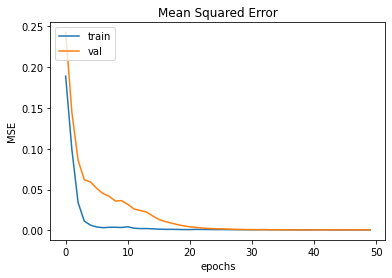

In [ ]:
# PLOTTING THE ACCURACY AND VALIDATION ACCURACY VS EPOCHS
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/DLCG_PART_2/ColorizerModel.h5")

(128, 128, 3)


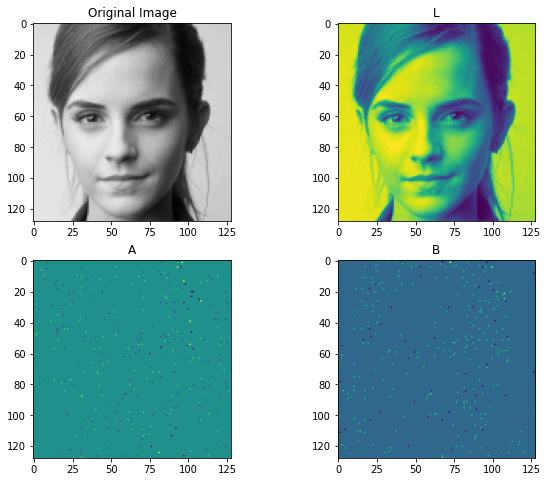

(128, 128, 3)

In [ ]:
img = cv2.imread("/content/2.png", )
img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
print(img.shape)
imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L, a, b = cv2.split(imageLAB)
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2,ncols=2,figsize=(10,8))

ax1.imshow(img)
ax1.set_title("Original Image")
ax2.imshow(L)
ax2.set_title("L")
ax3.imshow(a)
ax3.set_title("A")
ax4.imshow(b)
ax4.set_title("B")
plt.show()
imageLAB.shape

In [ ]:

L = L.reshape(1 , 1, 128, 128)
L = L/255
L.shape

(1, 1, 128, 128)

In [ ]:
# pred = model.predict(np.array([X_test[236]]))

pred = model.predict(L)
pred.shape

1/1 [==============================] - 0s 16ms/step


(1, 2, 128, 128)

In [ ]:
X_test[236].shape

(1, 128, 128)

In [ ]:

a = pred[0][0]
b = pred[0][1]
L = L.reshape(128,128)
a.shape, b.shape, L.shape

((128, 128), (128, 128), (128, 128))

In [ ]:
L = np.array(L * 255, dtype = np.uint8)
a = np.array(a * 255, dtype = np.uint8)
b = np.array(b * 255, dtype = np.uint8)

imgLAB = cv2.merge([L, a, b])
imgLAB.shape

(128, 128, 3)

Text(0.5, 1.0, 'Colorized')

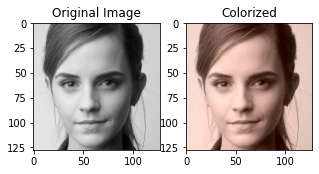

In [ ]:
image = cv2.cvtColor(imgLAB, cv2.COLOR_LAB2RGB)
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,8))

ax1.imshow(img)
ax1.set_title("Original Image")
ax2.imshow(image)
ax2.set_title("Colorized")

In [ ]:
def predict(imgpath):
  img = cv2.imread(imgpath)
  img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
  print(img.shape)
  imageLAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  L, a, b = cv2.split(imageLAB)
  L = L.reshape(1 , 1, 128, 128)
  L = L/255
  pred = model.predict(L)
  a = pred[0][0]
  b = pred[0][1]
  L = L.reshape(128,128)
  L = np.array(L * 255, dtype = np.uint8)
  a = np.array(a * 255, dtype = np.uint8)
  b = np.array(b * 255, dtype = np.uint8)

  imgLAB = cv2.merge([L, a, b])
  image = cv2.cvtColor(imgLAB, cv2.COLOR_LAB2RGB)
  fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(5,8))

  ax1.imshow(img)
  ax1.set_title("Original Image")
  ax2.imshow(image)
  ax2.set_title("Colorized")

(128, 128, 3)
1/1 [==============================] - 0s 18ms/step


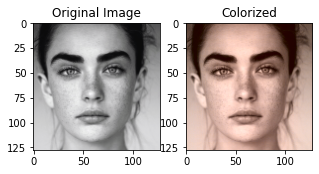

In [ ]:
predict("/content/3.png")